# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

***Целью*** данной работы является создание модели для решения регрессионной задачи определения возраста покупателя по его биометрическим данным(в данном случае по лицу). Для этого необходимо выполнить следующие ***задачи***:

1. Провести EDA для набора фотографий;
2. Подготовить данные к обучению;
3. Обучить модель и рассчитать необходимые метрики.

## Исследовательский анализ данных

Подключаем необходимые библиотеки:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
plt.rcParams.update({'font.size': 22})

Считываем входные данные:

In [3]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.
CPU times: user 586 ms, sys: 372 ms, total: 958 ms
Wall time: 1min 23s


Общее описание полученных данных:

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.shape

(7591, 2)

In [6]:
labels.describe(include='all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,000033.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Имеем 7591 изображение с людьми в возрасте от 1 до 100 лет в качестве данных для обучения и валидации модели. Для столбца **real_age** построим гистограмму для большей наглядности.

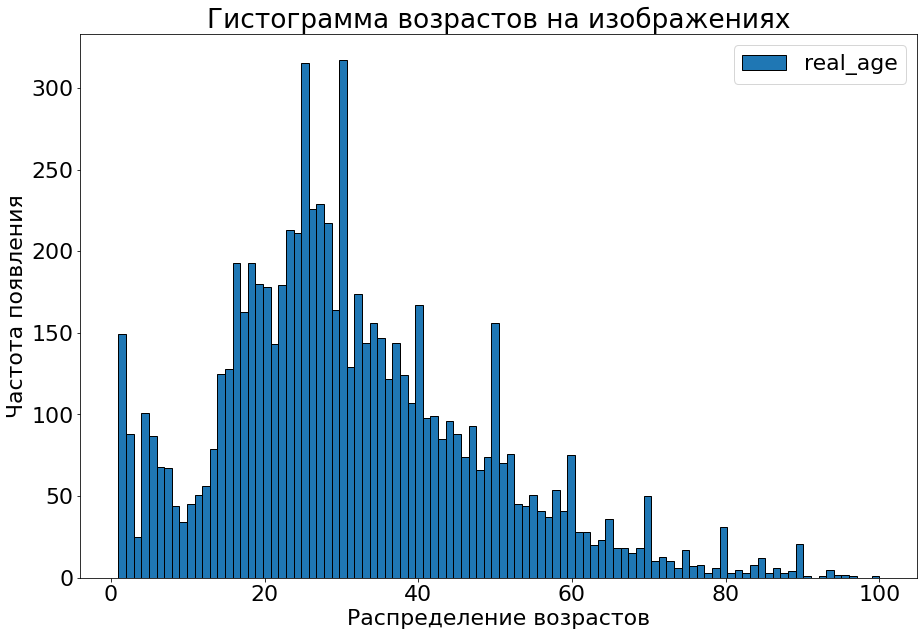

In [7]:
labels.plot.hist(bins=100, figsize=(15, 10), edgecolor='k', grid=False)
plt.title('Гистограмма возрастов на изображениях')
plt.xlabel('Распределение возрастов')
plt.ylabel('Частота появления')
plt.show()

Фотографий пожилых людей определённо меньше, чем более молодых. Также можно заметить, что основная масса примеров для обучения сосредоточена в окне(приблизительно) 14-40 лет. Разобъём все возраста на категории, более удобные для интерпретации.

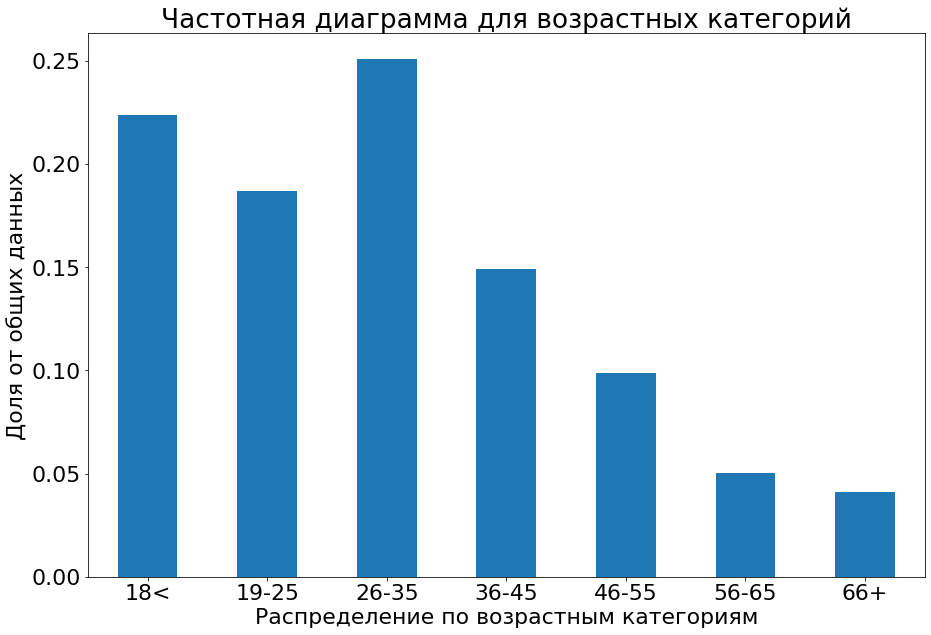

In [8]:
(pd.cut(labels['real_age'], bins=[-np.inf, 18, 25, 35, 45, 55, 65, np.inf])
 .value_counts(normalize=True)
 .sort_index()
 .plot.bar(figsize=(15, 10))
)
plt.xticks(
    labels=['18<', '19-25', '26-35', '36-45', '46-55', '56-65', '66+'],
    ticks=range(7), rotation=0)
plt.title('Частотная диаграмма для возрастных категорий')
plt.xlabel('Распределение по возрастным категориям')
plt.ylabel('Доля от общих данных')
plt.show()

Молодые люди до 35 лет составляют более чем 60 % выборки, в то время как примеров фотографий с пенсионерами и людьми предпенсионного возраста меньше 5 процентов для каждой категории. Это означает, что чем старше будет человек, возраст которого нужно определить, тем выше будет шанс модели ошибиться при предсказании его возраста.

Выведем несколько примеров изображений:

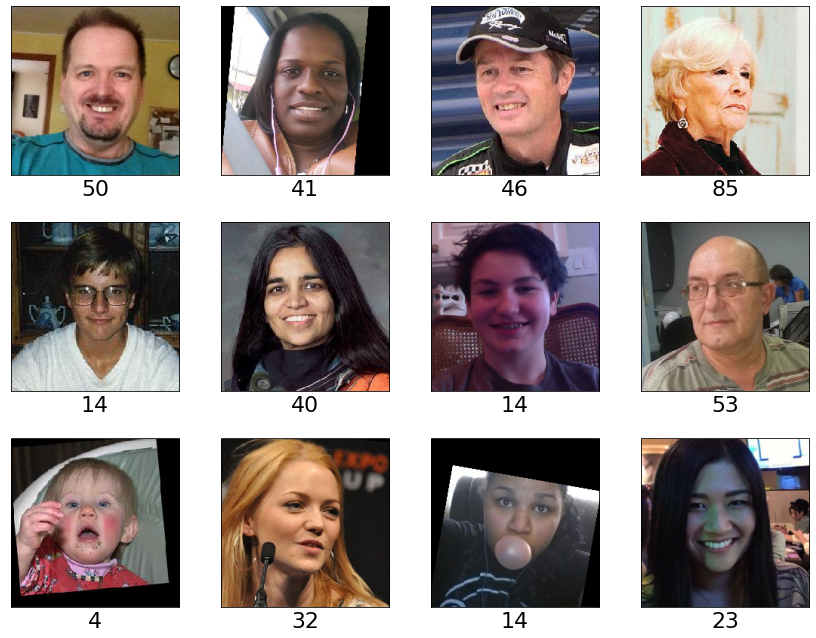

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12, 12))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

**Вывод**:

- В обучающей выборке содержится 7500+ цветных фотографий людей разных возрастов(1-100);
- Ориентация у фотографий в тренировочной выборке неоднородная, то есть имеются фотографии с наклонным ракурсом;
- Исходные изображения имели разный формат, но были приведены к размеру 224x224;
- Возраста людей на фотографиях распределены неравномерно и почти 2/3 выборки составляют молодые люди и порядка 10 % - пожилые.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(
        optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 166s - loss: 11.5479 - mean_absolute_error: 11.5485 - val_loss: 14.8971 - val_mean_absolute_error: 14.8893
Epoch 2/10
356/356 - 38s - loss: 9.3943 - mean_absolute_error: 9.3950 - val_loss: 19.6148 - val_mean_absolute_error: 19.6003
Epoch 3/10
356/356 - 38s - loss: 8.5243 - mean_absolute_error: 8.5252 - val_loss: 11.1600 - val_mean_absolute_error: 11.1596
Epoch 4/10
356/356 - 38s - loss: 7.8361 - mean_absolute_error: 7.8367 - val_loss: 10.3978 - val_mean_absolute_error: 10.3807
Epoch 5/10
356/356 - 38s - loss: 7.1255 - mean_absolute_error: 7.1256 - val_loss: 8.2951 - val_mean_absolute_error: 8.2964
Epoch 6/10
356/356 - 38s - loss: 6.4536 - mean_absolute_error: 6.4544 - val_loss: 9.4618 - val_mean_absolute_error: 9.4429
Epoch 7/10
356/356 - 38s - loss: 6.0129 - mean_absolute_error: 6.0134 - val_loss: 9.7809 - val_mean_absolute_error: 9.7769
Epoch 8/10
356/356 - 38s - loss: 5.5971 - mean_absolute_error: 5.5969 - val_loss: 8.4436 - val_mean_absolute_error: 8.4399
Epoch 9/10
356/356 - 38s - loss: 5.1216 - mean_absolute_error: 5.1212 - val_loss: 8.4890 - val_mean_absolute_error: 8.4794
Epoch 10/10
356/356 - 38s - loss: 4.8980 - mean_absolute_error: 4.8982 - val_loss: 7.3693 - val_mean_absolute_error: 7.3746

119/119 - 10s - loss: 7.3693 - mean_absolute_error: 7.3746
Test MAE: 7.3746

```

## Анализ обученной модели

Модель обучалась на базе архитектуры ResNet50 с оптимизатором Adam и дала удовлетворительные результаты на валидационной выборке(7.3746). Поскольку пороговое значение составляет 5.4, то на этом результате можно остановиться, однако возможно что дальнейшее обучение может улучшить полученные результат. Полученные результаты рассмотрим более наглядно:

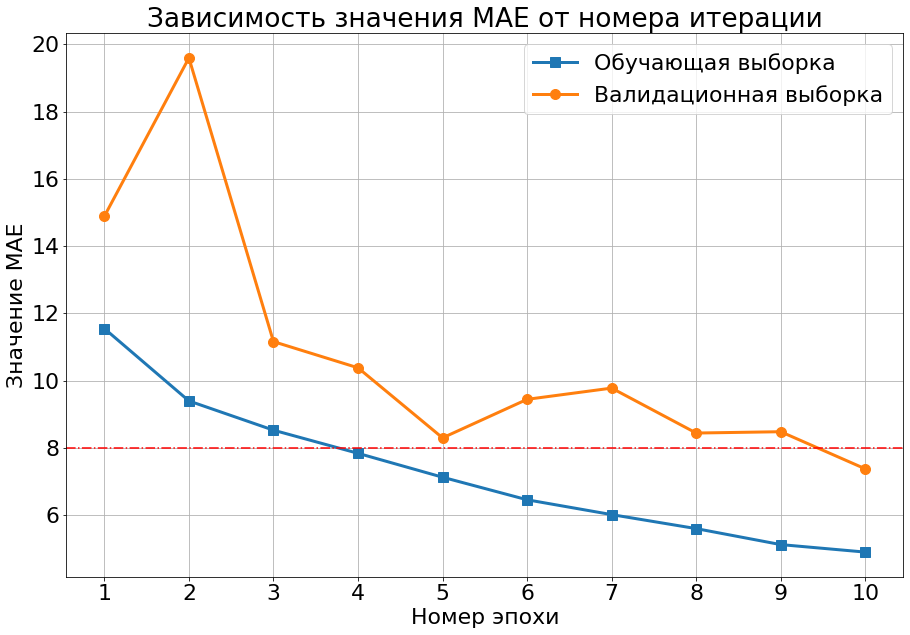

In [10]:
train_mse = [11.5485, 9.3950, 8.5252, 7.8367, 7.1256, 6.4544, 6.0134, 5.5969, 5.1212, 4.8982]
val_mse = [14.8893, 19.6003, 11.1596, 10.3807, 8.2964, 9.4429, 9.7769, 8.4399, 8.4794, 7.3746]

plt.figure(figsize=(15, 10))
plt.plot(train_mse, '-s', val_mse, '-o', lw=3, ms=10)
plt.axhline(8, c='r', ls='-.')
plt.title('Зависимость значения MAE от номера итерации')
plt.xlabel('Номер эпохи')
plt.ylabel('Значение MAE')
plt.xticks(ticks=range(10), labels=range(1, 11, 1))
plt.legend(['Обучающая выборка', 'Валидационная выборка'])
plt.grid()
plt.show()

## Выводы

1. Данные выгружены и проанализированы, они содержат 7500+ фотографий различных людей в возрасте от 1 до 100 лет. Большая часть фотографий содержат примеры молодых людей, в то время как фотографий людей старше 55 лет всего 1/10 часть от всех данных, то есть выборка несбалансированна в отношении возрастных категорий;
2. Из визуального анализа следует отметить, что обучение и определение реального возраста будут затруднять лишние предметы на изображениях - жвачка, микрофоны, наушники, головные уборы и тд.;
3. Обучена модель на базе ResNet50, получено хорошее значение MAE на валидационной выборке = 7.3746 < 8 за 10 эпох;
4. В среднем модель ошибается на +- 7 лет при определении возраста, что не всегда критично ввиду того что возрастные категории не имеют чёткой градации, а также покупательские интересы соседних возрастных групп могут и совпадать;
5. Высокая скорость и точность работы модели достигается за счёт использования современных нейросетевых архитектур и использования GPU.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы